## Prelab 8

Due to current issues with our clamp power limit, we will be operating at the following:
* Output voltage Vo = 8.08 V
* Output power Pout = 13 W
* Duty cycle D = 30%

In [1]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

### Semiconductor Losses
##### Conduction
When the MOSFET operates in the ohmic region, it behaves similiarly to a resistor. We can use its resistance from drain-to-source based on its $V_{GS}$ curve given in the data sheet.

For our circuit, we know that the the UC2844 has a 13.5 V typical output voltage based on the datasheet. Since the voltage over the shunt resistor rises, however, this will be at a minimum of about 13.25 V. For the MOSFET P/N FDP61N10, we refer to the chart below using the drain current between 0 to 5.4 A and our $V_{GS}$ is closer to 10 V than 20 V. We get a $R_{DS(ON)}$ of 0.0325 $\Omega$.

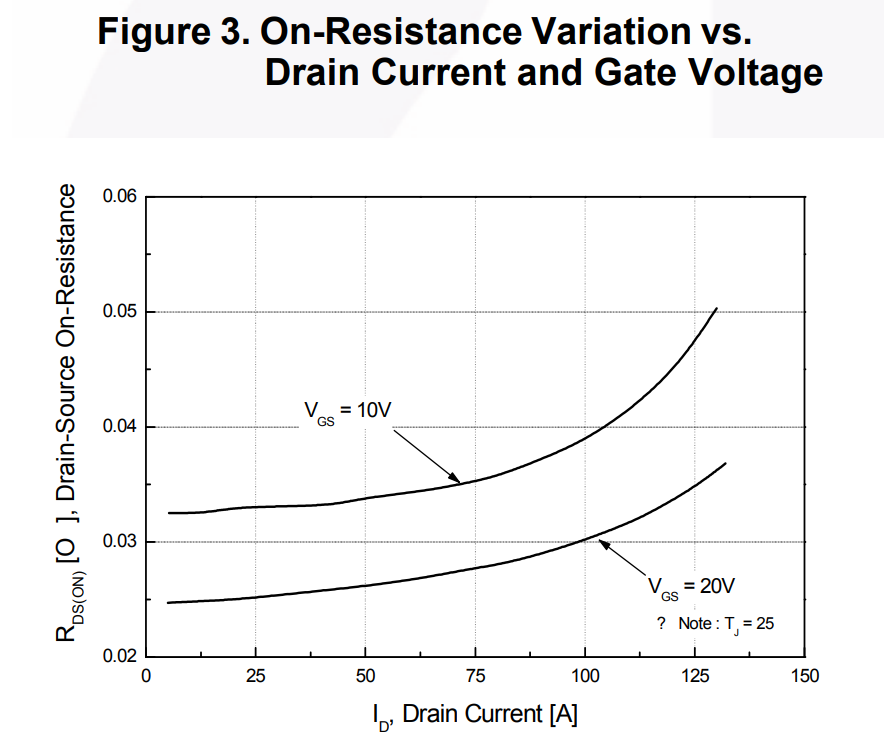

To get an average per switching period, we can use $\langle P_{Ts} \rangle = i_{rms}^2R_{DS(ON)}$ to give us a power value.

In [2]:
R_DSON = 0.03 * units.ohm
D = 0.3 # Duty cycle
ipk = 5.4 * units.amp
irms = np.sqrt(D/3) * ipk

P_SC_CD = ipk**2 * R_DSON
print(f"The conduction losses from the semiconductor are about {P_SC_CD.to('watt')}.")

The conduction losses from the semiconductor are about 0.8748000000000001 W.


##### Switching
We can use the current through the MOSFET times the voltage from drain to source to get instantaneous power loss. If we integrate this quantity over a switching period, we can get the energy lost per period. It then can be normalized to be average power loss over switching period.

4.544063306666674×10⁻⁵ J
MOSFET Switching Losses: 2.272031653333337 W


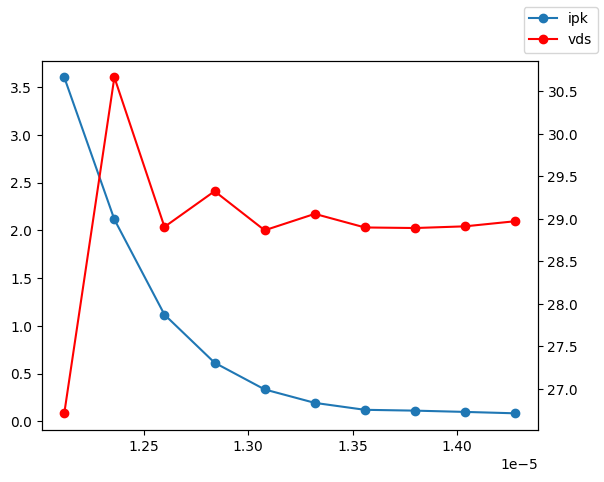

In [3]:
data = pd.read_csv("../lab7/data/baseline_full.csv")
increment = float(data["Increment"][0])
data = data.iloc[1: , :]
data = data.astype(float)

time = data["X"].to_numpy() * increment
ipk = data["CH1"].to_numpy() * 20
vds = data["CH2"].to_numpy()

n_bins = 100 # choose how many samples to use 
bin_size = (max(time) - min(time))/n_bins
time_res, vds_res, ipk_res = [],[], []
# Resample the data with consistent density 
for i in range(n_bins-1): 
    lower = time >= min(time)+i*bin_size
    higher = time < min(time)+(i+1)*bin_size
    time_res.append(np.mean(time[np.where(lower & higher)]))
    vds_res.append(np.mean(vds[np.where(lower & higher)]))
    ipk_res.append(np.mean(np.abs(ipk[np.where(lower & higher)])))

start_tick = int(n_bins * 0.5) 
end_tick = int(n_bins * 0.6)

p = np.multiply(ipk, vds)
p_res = np.multiply(ipk_res[start_tick:end_tick], vds_res[start_tick:end_tick])
e = np.trapz(p, time)
e_res = np.trapz(p_res, time_res[start_tick:end_tick]) * units.joule


fig, ax = plt.subplots()  
twinax = ax.twinx()
ax.plot(time_res[start_tick:end_tick], ipk_res[start_tick:end_tick], '-o', label='ipk')
twinax.plot(time_res[start_tick:end_tick], vds_res[start_tick:end_tick], 'r-o', label='vds')
fig.legend()
print(e_res)


fs = 50e3 / units.second
Ts = 1/fs
P_SC_SW = e_res / Ts
print("MOSFET Switching Losses:", P_SC_SW.to('watt'))

### Transformer
##### Conduction Losses
We can have conduction losses on both sides of the transformer.
$\langle P_{Ts} \rangle = i_{rms}^2R$
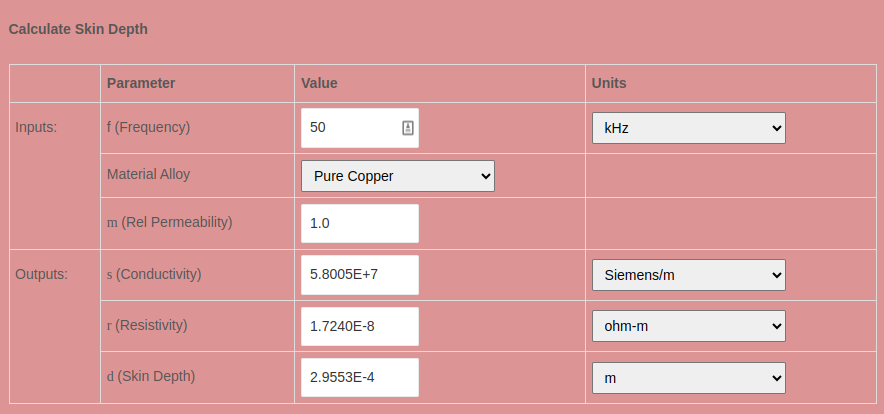

The skin is less than our material with given parameters, so we know the resistivity from the calculator.

In [4]:
R = 1.724e-8 * units.ohm / units.meter
mean_turn_length = 33 * units.mm
a = 0.731

n_primary = 8
n_secondary = 7
irms_primary = irms
irms_secondary = irms / a

loss_primary = (irms_primary**2 * R *  n_primary * mean_turn_length).to('watt').to_compact()
loss_secondary = (irms_secondary**2 * R * n_secondary * mean_turn_length).to('watt').to_compact()
P_TR_CD = loss_primary + loss_secondary

print(f"The transformer conduction loss is {P_TR_CD} with {loss_primary} being from the primary winding and {loss_secondary} being from the secondary.")


The transformer conduction loss is 35.00388138969603 nW with 13.271765760000003 nW being from the primary winding and 21.732115629696032 nW being from the secondary.


##### Eddy Current Conduction Losses
These are negligible due to our ferrite material and low frequencies.

### RC Snubber
I used PLECS to model the losses of the snubber resistor. The average power loss over the switching period was simulated to be 0.227 W.


In [5]:
P_RC_SN = 0.227 * units.watt

### RCD Clamp

I used PLECS to model the losses from the resistor and switching of the diode in the clamp. They came out to be 0.806 W and 0.026 W respectively. Since the diode has such a small switching loss, its conduction loss is negligible.  


In [6]:
P_RCD_R = 0.806 * units.watt
P_RCD_SW = 0.026 * units.watt

### Diode Losses
The diode on the secondary side was another component expected to be lossy. In PLECS, I modeled it and found the switching losses to be 1.14 W. Per the datasheet, the conduction losses are very small and would be negligible.

In [7]:
P_D_SW = 1.14 * units.watt

### Totals

Total Loss: 5.345831688337218 W


/home/lila/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3219: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x, np.float32)


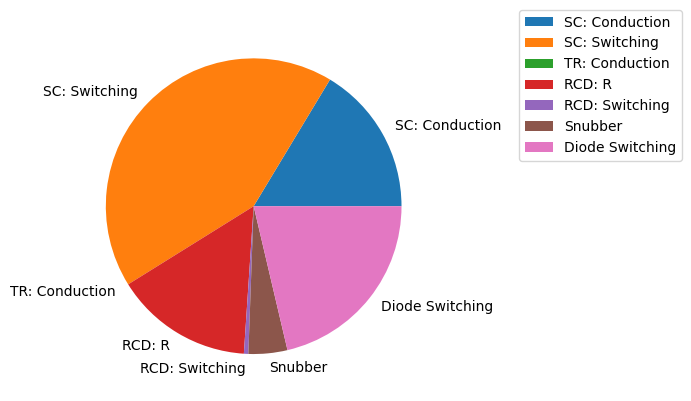

In [8]:
total = (P_SC_CD + P_SC_SW + P_TR_CD + P_RC_SN + P_RCD_R + P_RCD_SW + P_D_SW)
labels = 'SC: Conduction', 'SC: Switching', 'TR: Conduction', 'RCD: R', 'RCD: Switching', 'Snubber', 'Diode Switching'
sizes = [P_SC_CD/total * 100,
         P_SC_SW/total * 100,
         P_TR_CD/total * 100,
         P_RCD_R/total * 100,
         P_RCD_SW/total * 100,
         P_RC_SN/total * 100,
         P_D_SW/total * 100]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
ax.legend(bbox_to_anchor=(1.2, 1.05))
print("Total Loss:", total.to('watt'))